## Imports

In [9]:
import sys
from cifar_very_tiny import *
from cifar_tiny import *
from cifar_dataset import *   
from resnet import * 
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

## Load data

In [10]:
train_loader, test_loader = cifar10_loader(batch_size=128, maxsize=10112)

Files already downloaded and verified
Files already downloaded and verified


## Some stuff

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch_num = 50

In [12]:
def accuracy(model):
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.eq(torch.argmax(out, 1), y).sum()
            total += len(x)
    return (correct / total).cpu().detach().numpy()

In [13]:
kl = nn.KLDivLoss(reduction="batchmean")
sm = nn.Softmax(dim=1)

def distill(out, teacher_out, temp):
    g = sm(out / temp)
    f = F.log_softmax(teacher_out / temp)
    return kl(f, g)

## Train teacher model

In [14]:
teacher = ResNet18(10).to(device)
optim = torch.optim.Adam(teacher.parameters())
crit = nn.CrossEntropyLoss()
tq = tqdm(range(epoch_num))
for epoch in tq:
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        teacher.zero_grad()
        out = teacher(x)
        loss = crit(teacher(x), y)
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        optim.step()
    tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:])))
print("teacher accuracy", accuracy(teacher))

  0%|          | 0/50 [00:00<?, ?it/s]

teacher accuracy 0.69479996


## Train students without teacher

### Tiny student

In [15]:
tiny_solo_results = []
for _ in range(5):
    student = Cifar_Tiny(10).to(device)
    optim = torch.optim.Adam(student.parameters())
    crit = nn.CrossEntropyLoss()
    tq = tqdm(range(epoch_num))
    for epoch in tq:
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()
            out = student(x)
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
        tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:])))
    tiny_solo_results.append(accuracy(student))
    print("accuracy", tiny_solo_results[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.57739997


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5822


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5733


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5665


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.57919997


### Very Tiny Student

In [16]:
very_tiny_solo_results = []
for _ in range(5):
    student = Cifar_Very_Tiny(10).to(device)
    optim = torch.optim.Adam(student.parameters())
    crit = nn.CrossEntropyLoss()
    tq = tqdm(range(epoch_num))
    for epoch in tq:
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()
            out = student(x)
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
        tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:])))
    very_tiny_solo_results.append(accuracy(student))
    print("accuracy", very_tiny_solo_results[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5114


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.50949997


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5082


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.522


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5226


## Train students with distillation

### Tiny student

In [25]:
tiny_results = []
for _ in range(20):
    beta = np.random.uniform()
    temp = 10 ** (np.random.uniform(low=-1, high=1))  # температура от 0.1 до 10
    print("hyperparameters", beta, temp)
    student = Cifar_Tiny(10).to(device)
    optim = torch.optim.Adam(student.parameters())
    crit = nn.CrossEntropyLoss()
    tq = tqdm(range(epoch_num))
    for _ in tq:
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()
            out = student(x)
            with torch.no_grad():
                teacher_out = teacher(x)
            student_loss = crit(student(x), y)
            distillation_loss = distill(out, teacher_out, temp)
            loss = (1 - beta) * student_loss + beta * distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
        tq.set_description("current loss:{}".format(np.mean(losses[-10:])))
    tiny_results.append((accuracy(student), beta, temp))
    print("accuracy", tiny_results[-1][0])

hyperparameters 0.8307458553862042 1.5173685011896443


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_78534/2137037151.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(teacher_out / temp)


accuracy 0.5876
hyperparameters 0.025473322393688602 0.2186827460403856


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.7061287528457864 0.8001914630134117


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5915
hyperparameters 0.30385202781943244 4.512715098082257


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5883
hyperparameters 0.9129538483948554 1.362480388787882


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.59
hyperparameters 0.7303126165238956 1.79264908985528


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.58419997
hyperparameters 0.1897618459797421 1.3751495327537533


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5859
hyperparameters 0.024893711429559096 2.048231936084814


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5801
hyperparameters 0.0902209107406553 0.1888505262699139


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.7212662759511065 2.092889516324546


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5897
hyperparameters 0.8509617304077117 0.4581128374102514


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.9363332466606623 4.125159253369082


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5815
hyperparameters 0.468237233200523 0.39631290693369264


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.7791245952676875 0.2596793274305738


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.336805864803118 2.1917606916407966


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.57269996
hyperparameters 0.23826763551817598 0.9152685666237567


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.9407919989409465 4.3691658893240035


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.58599997
hyperparameters 0.10819177703180893 0.5397627620668899


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.16620324761424154 1.3537495116926679


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.57699996
hyperparameters 0.5411937480090906 1.1287427277668582


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5728


### Very Tiny Student


In [27]:
very_tiny_results = []
for _ in range(20):
    beta = np.random.uniform()
    temp = 10 ** (np.random.uniform(low=-1, high=1))  # температура от 0.1 до 10
    print("hyperparameters", beta, temp)
    student = Cifar_Very_Tiny(10).to(device)
    optim = torch.optim.Adam(student.parameters())
    crit = nn.CrossEntropyLoss()
    tq = tqdm(range(epoch_num))
    for _ in tq:
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()
            out = student(x)
            with torch.no_grad():
                teacher_out = teacher(x)
            student_loss = crit(student(x), y)
            distillation_loss = distill(out, teacher_out, temp)
            loss = (1 - beta) * student_loss + beta * distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
        tq.set_description("current loss:{}".format(np.mean(losses[-10:])))
    very_tiny_results.append((accuracy(student), beta, temp))
    print("accuracy", very_tiny_results[-1][0])

hyperparameters 0.9838254824319026 0.8540263882327366


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_78534/2137037151.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(teacher_out / temp)


accuracy 0.099999994
hyperparameters 0.6120720589584205 0.9171413347603511


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5351
hyperparameters 0.8969368762860714 1.4656441232779813


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5376
hyperparameters 0.9910525865907566 6.816581082895519


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.555
hyperparameters 0.03535821227654057 7.197651906422851


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5141
hyperparameters 0.18929398699202693 0.28896545110346067


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.08381569358907781 0.41129592311150787


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.53389996
hyperparameters 0.06741115588759805 0.49540225039322733


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5463
hyperparameters 0.09129074712182617 0.10432608874175646


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.08423726267416975 3.8211975188115654


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5169
hyperparameters 0.4043295696312911 0.6485376898716306


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5405
hyperparameters 0.20929297298233496 0.9224429476262017


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5391
hyperparameters 0.10060668387345273 3.3817910773672737


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5312
hyperparameters 0.32637225881108156 1.203515072504985


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5439
hyperparameters 0.16891701075753007 0.14931813253277249


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.9011140186745105 0.2621924165134868


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.6475574696273085 0.17117587829127384


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.36458163694425516 2.060566896875669


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5437
hyperparameters 0.2597404695091411 0.2814333394984451


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.099999994
hyperparameters 0.11491053350631475 2.5734072986058845


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 0.5256


## Visualization

### Accuracy box plot

/tmp/ipykernel_78534/3419876765.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['teacher', 'tiny_solo', 'very_tiny_solo', 'tiny', 'very_tiny'])


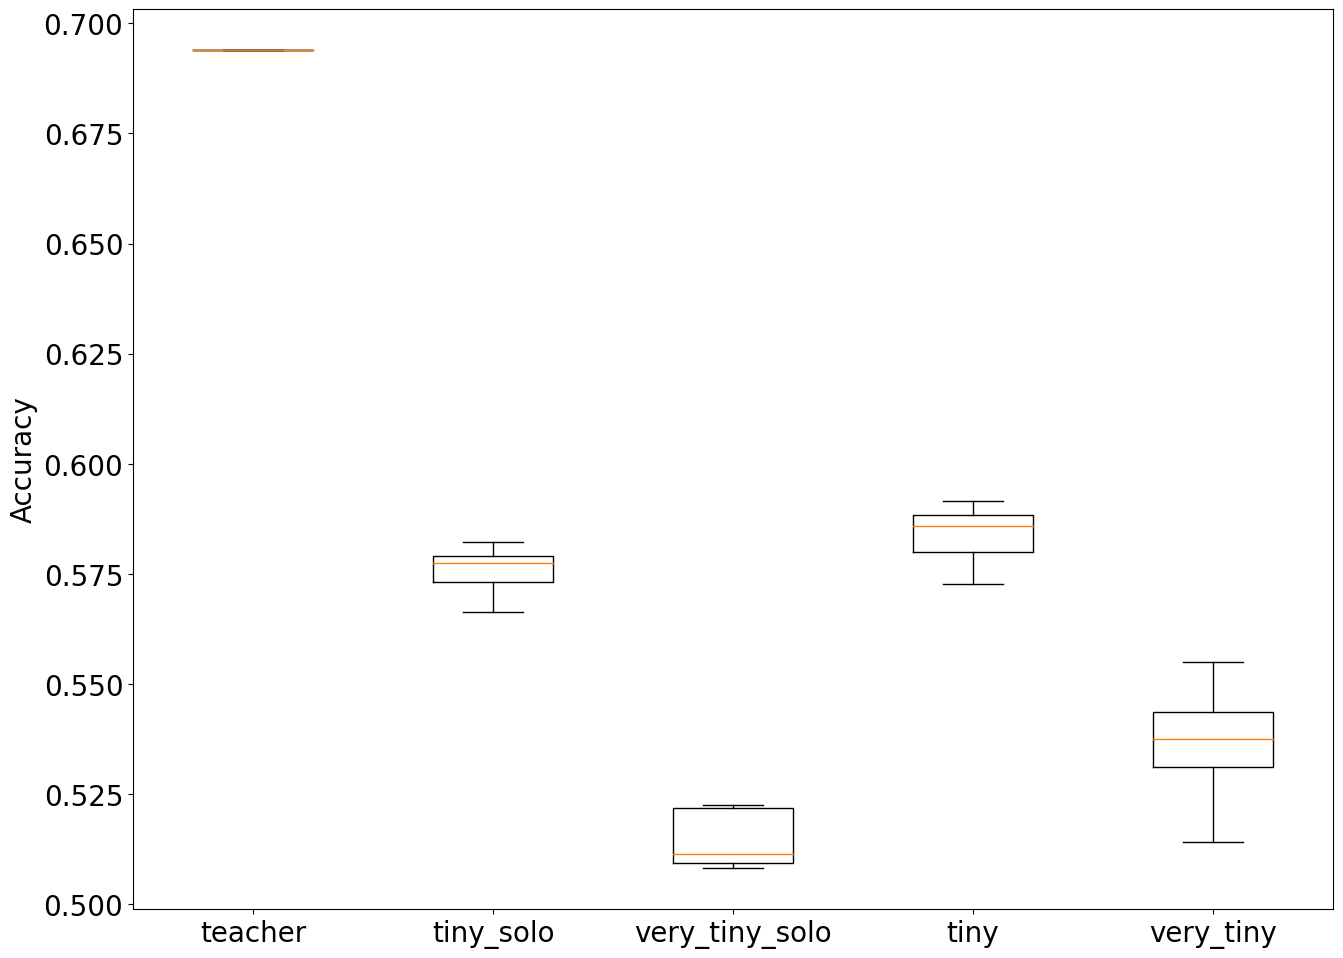

In [67]:
teacher_result = [accuracy(teacher)]

data = [teacher_result, tiny_solo_results, very_tiny_solo_results, [x[0] for x in tiny_results if x[0] > 0.1], [x[0] for x in very_tiny_results if x[0] > 0.1]]
 
fig = plt.figure()
 
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xticklabels(['teacher', 'tiny_solo', 'very_tiny_solo', 'tiny', 'very_tiny'])
plt.ylabel('Accuracy')
ax.boxplot(data)

plt.savefig('../figures/box_hinton_model_accuracy.png', bbox_inches='tight', pad_inches=0)
plt.show()

### Accuracy - beta in students

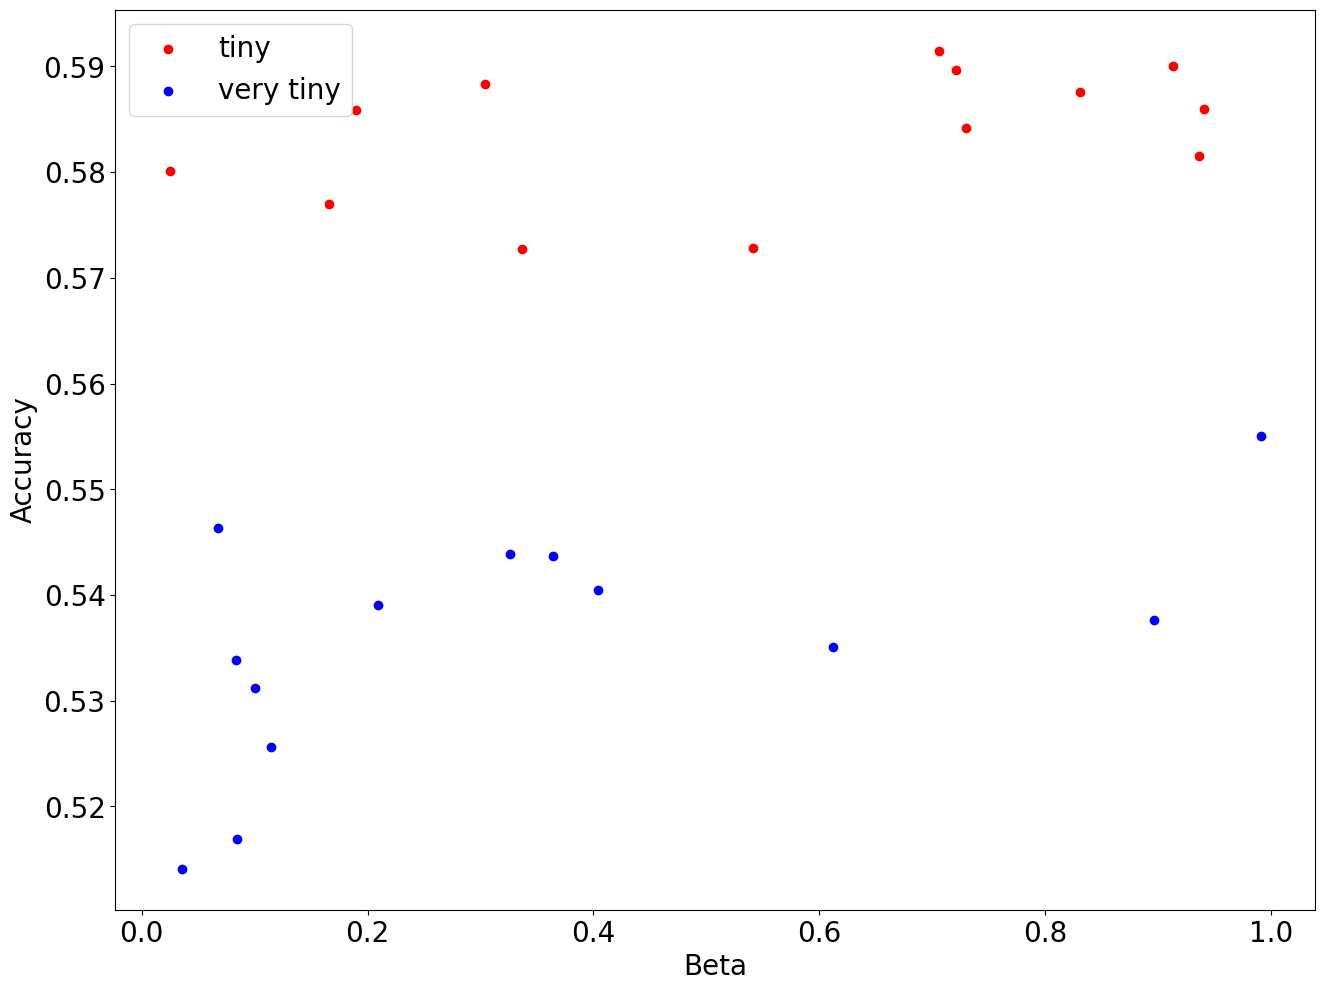

In [66]:
fig = plt.figure()
 
ax = fig.add_axes([0, 0, 1, 1])

ax.scatter([x[1] for x in tiny_results if x[0] > 0.1], [x[0] for x in tiny_results if x[0] > 0.1], c='r', label='tiny')
ax.scatter([x[1] for x in very_tiny_results if x[0] > 0.1], [x[0] for x in very_tiny_results if x[0] > 0.1], c='b', label='very tiny')
plt.legend(loc='best')
plt.xlabel('Beta')
plt.ylabel('Accuracy')

plt.savefig('../figures/scatter_hinton_beta_acc.png', bbox_inches='tight', pad_inches=0)
plt.show()

### Accuracy - temperature in students

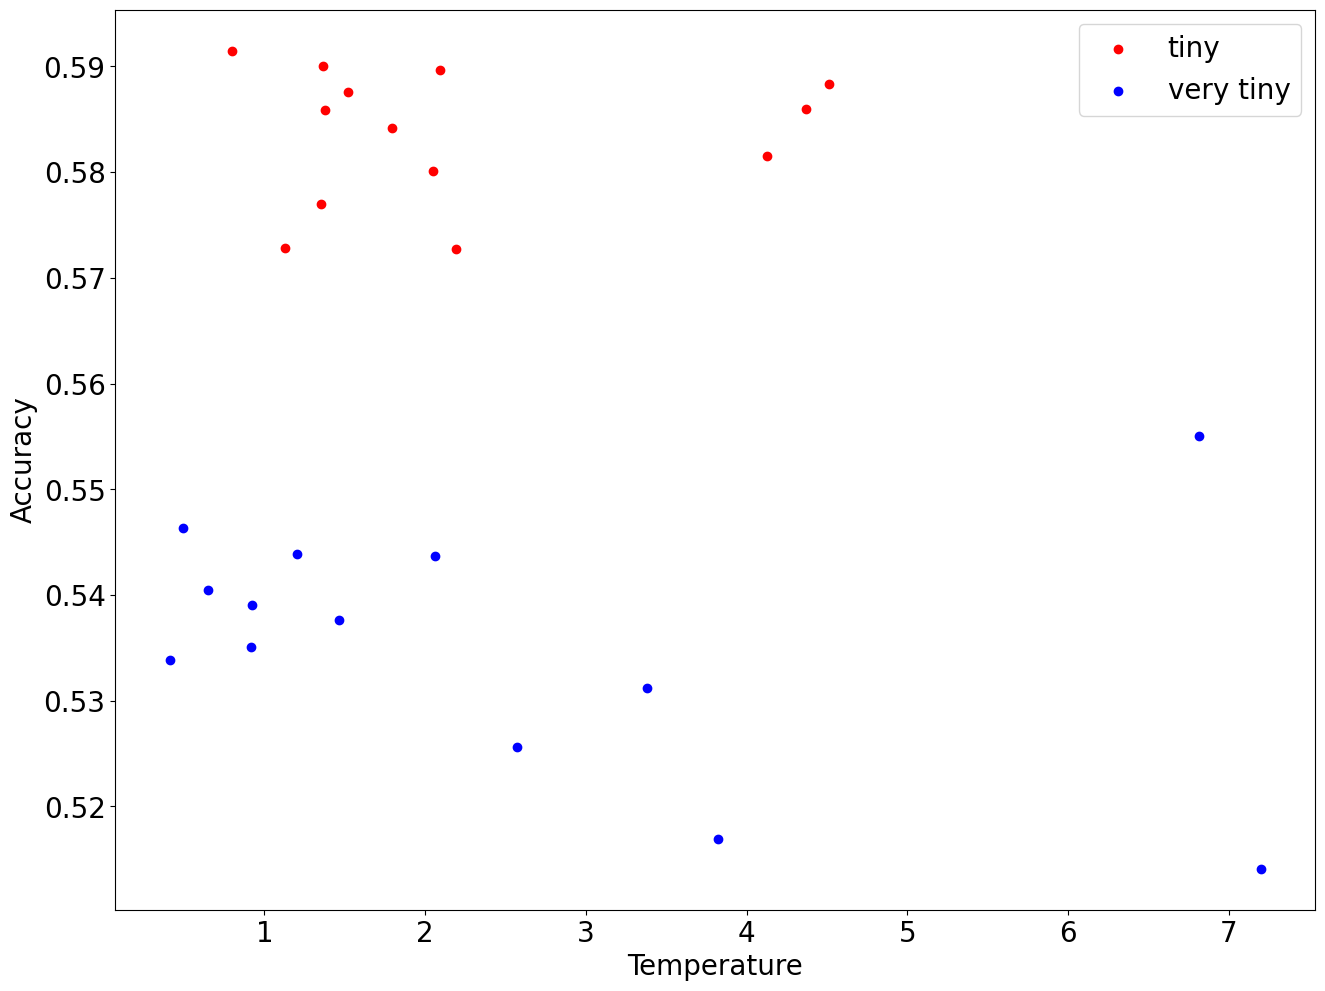

In [65]:
fig = plt.figure()
 
ax = fig.add_axes([0, 0, 1, 1])

ax.scatter([x[2] for x in tiny_results if x[0] > 0.1], [x[0] for x in tiny_results if x[0] > 0.1], c='r', label='tiny')
ax.scatter([x[2] for x in very_tiny_results if x[0] > 0.1], [x[0] for x in very_tiny_results if x[0] > 0.1], c='b', label='very tiny')
plt.legend(loc='best')
plt.xlabel('Temperature')
plt.ylabel('Accuracy')

plt.savefig('../figures/scatter_hinton_temp_acc.png', bbox_inches='tight', pad_inches=0)
plt.show()